/Users/lubek/Documents/anaconda/anaconda3/envs/weather_maps/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


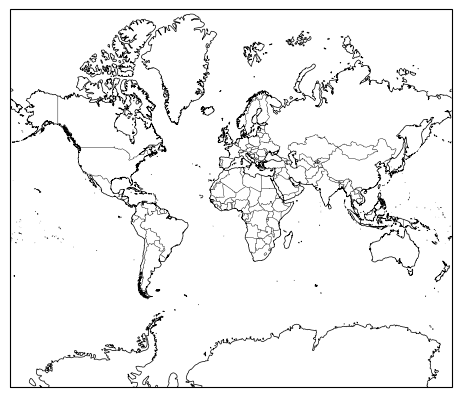

In [1]:
import xarray as xr
import cartopy.feature as cf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

projection = ccrs.Mercator()

plt.figure(dpi=100, figsize=(10,5))
ax = plt.axes(projection=projection)
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
plt.show()

Text(0.5, 0.98, 'Custom extents calculated only from degrees')

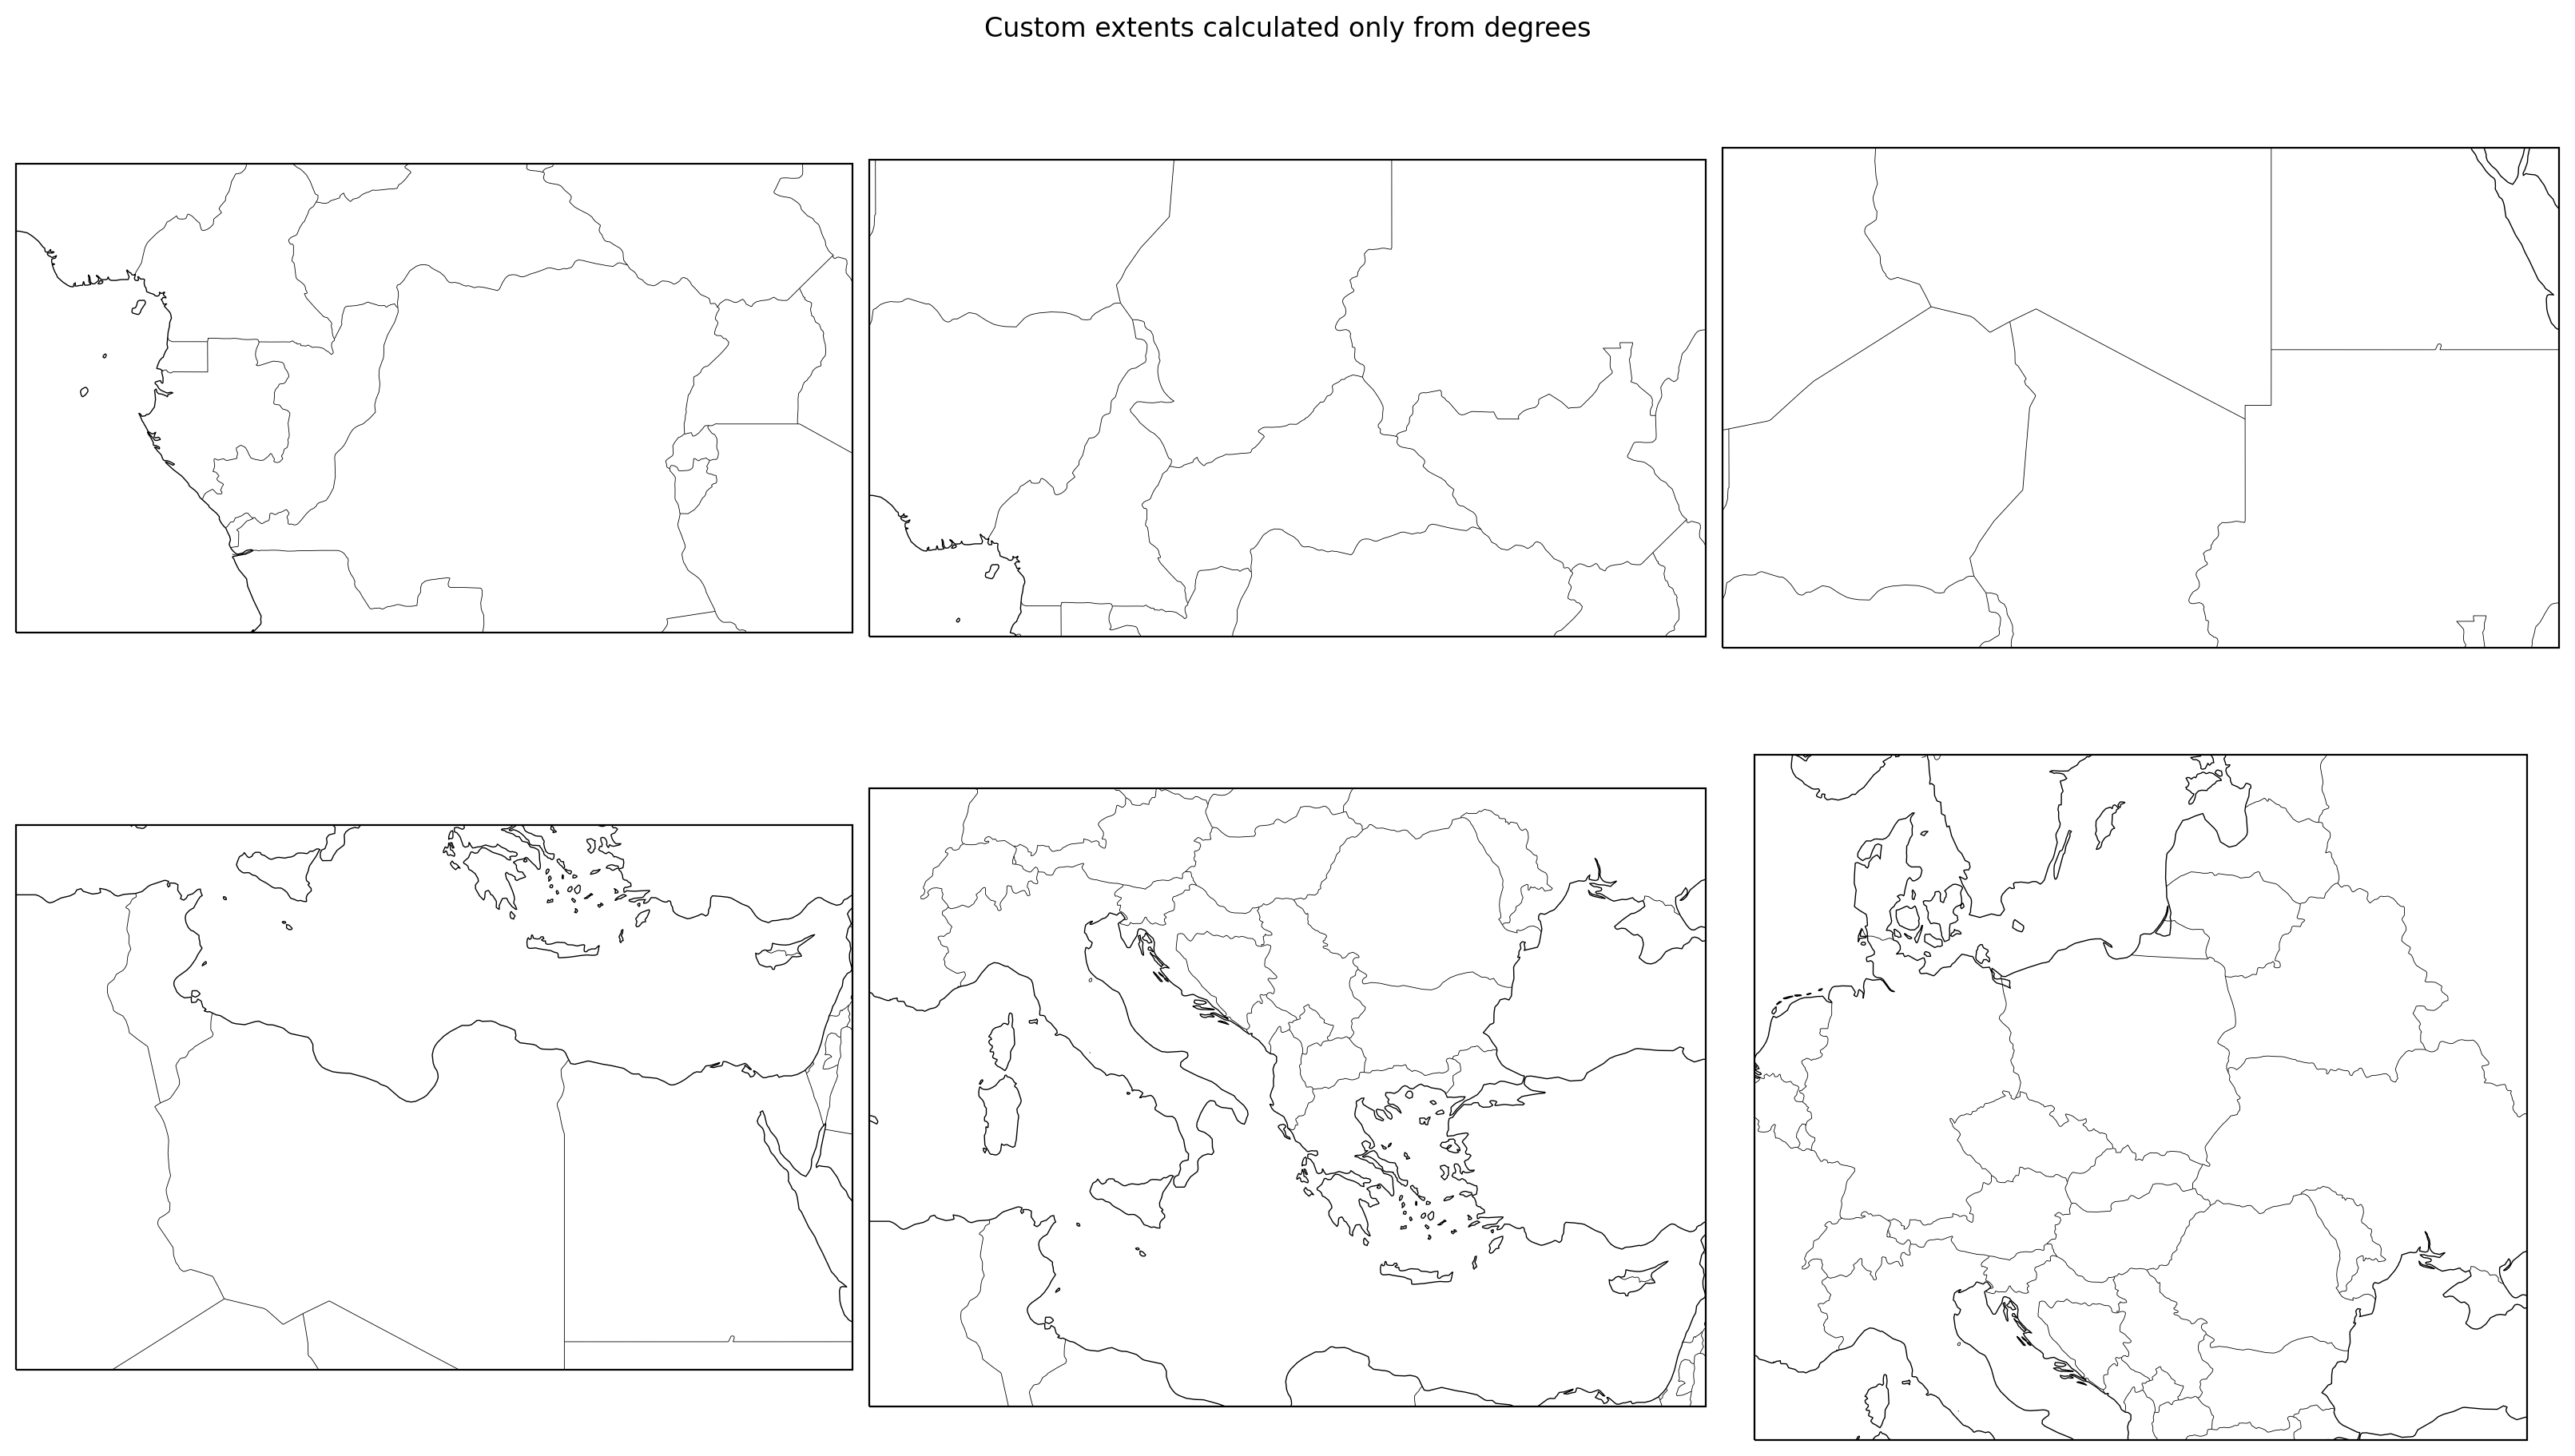

In [2]:
from itertools import repeat

def generate_extent_demo(center_point):
    minimum_longitude = center_point[0]-16
    maximum_longitude = center_point[0]+16 
    minimum_latitude = center_point[1]-9
    maximum_latitude = center_point[1]+9
    
    return minimum_longitude,maximum_longitude,  minimum_latitude, maximum_latitude

longitude = 20
latitudes = [0,10,20,30,40,50]

mercator_crs = ccrs.Mercator()
fig, axs = plt.subplots(2,3, dpi=200, figsize=(16,9), subplot_kw={'projection': mercator_crs}, constrained_layout=True, facecolor="white")
axs = axs.flatten()

for n, center_point in enumerate(zip(repeat(longitude), latitudes)):
    lon_min, lon_max, lat_min, lat_max = generate_extent_demo(center_point)
    axs[n].set_extent([lon_min, lon_max, lat_min, lat_max], crs = ccrs.PlateCarree())
    # Draw coastlines and borders
    axs[n].add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    axs[n].add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
    
plt.suptitle("Custom extents calculated only from degrees")

Text(0.5, 0.98, 'Custom extents calculated in Mercator coordinates')

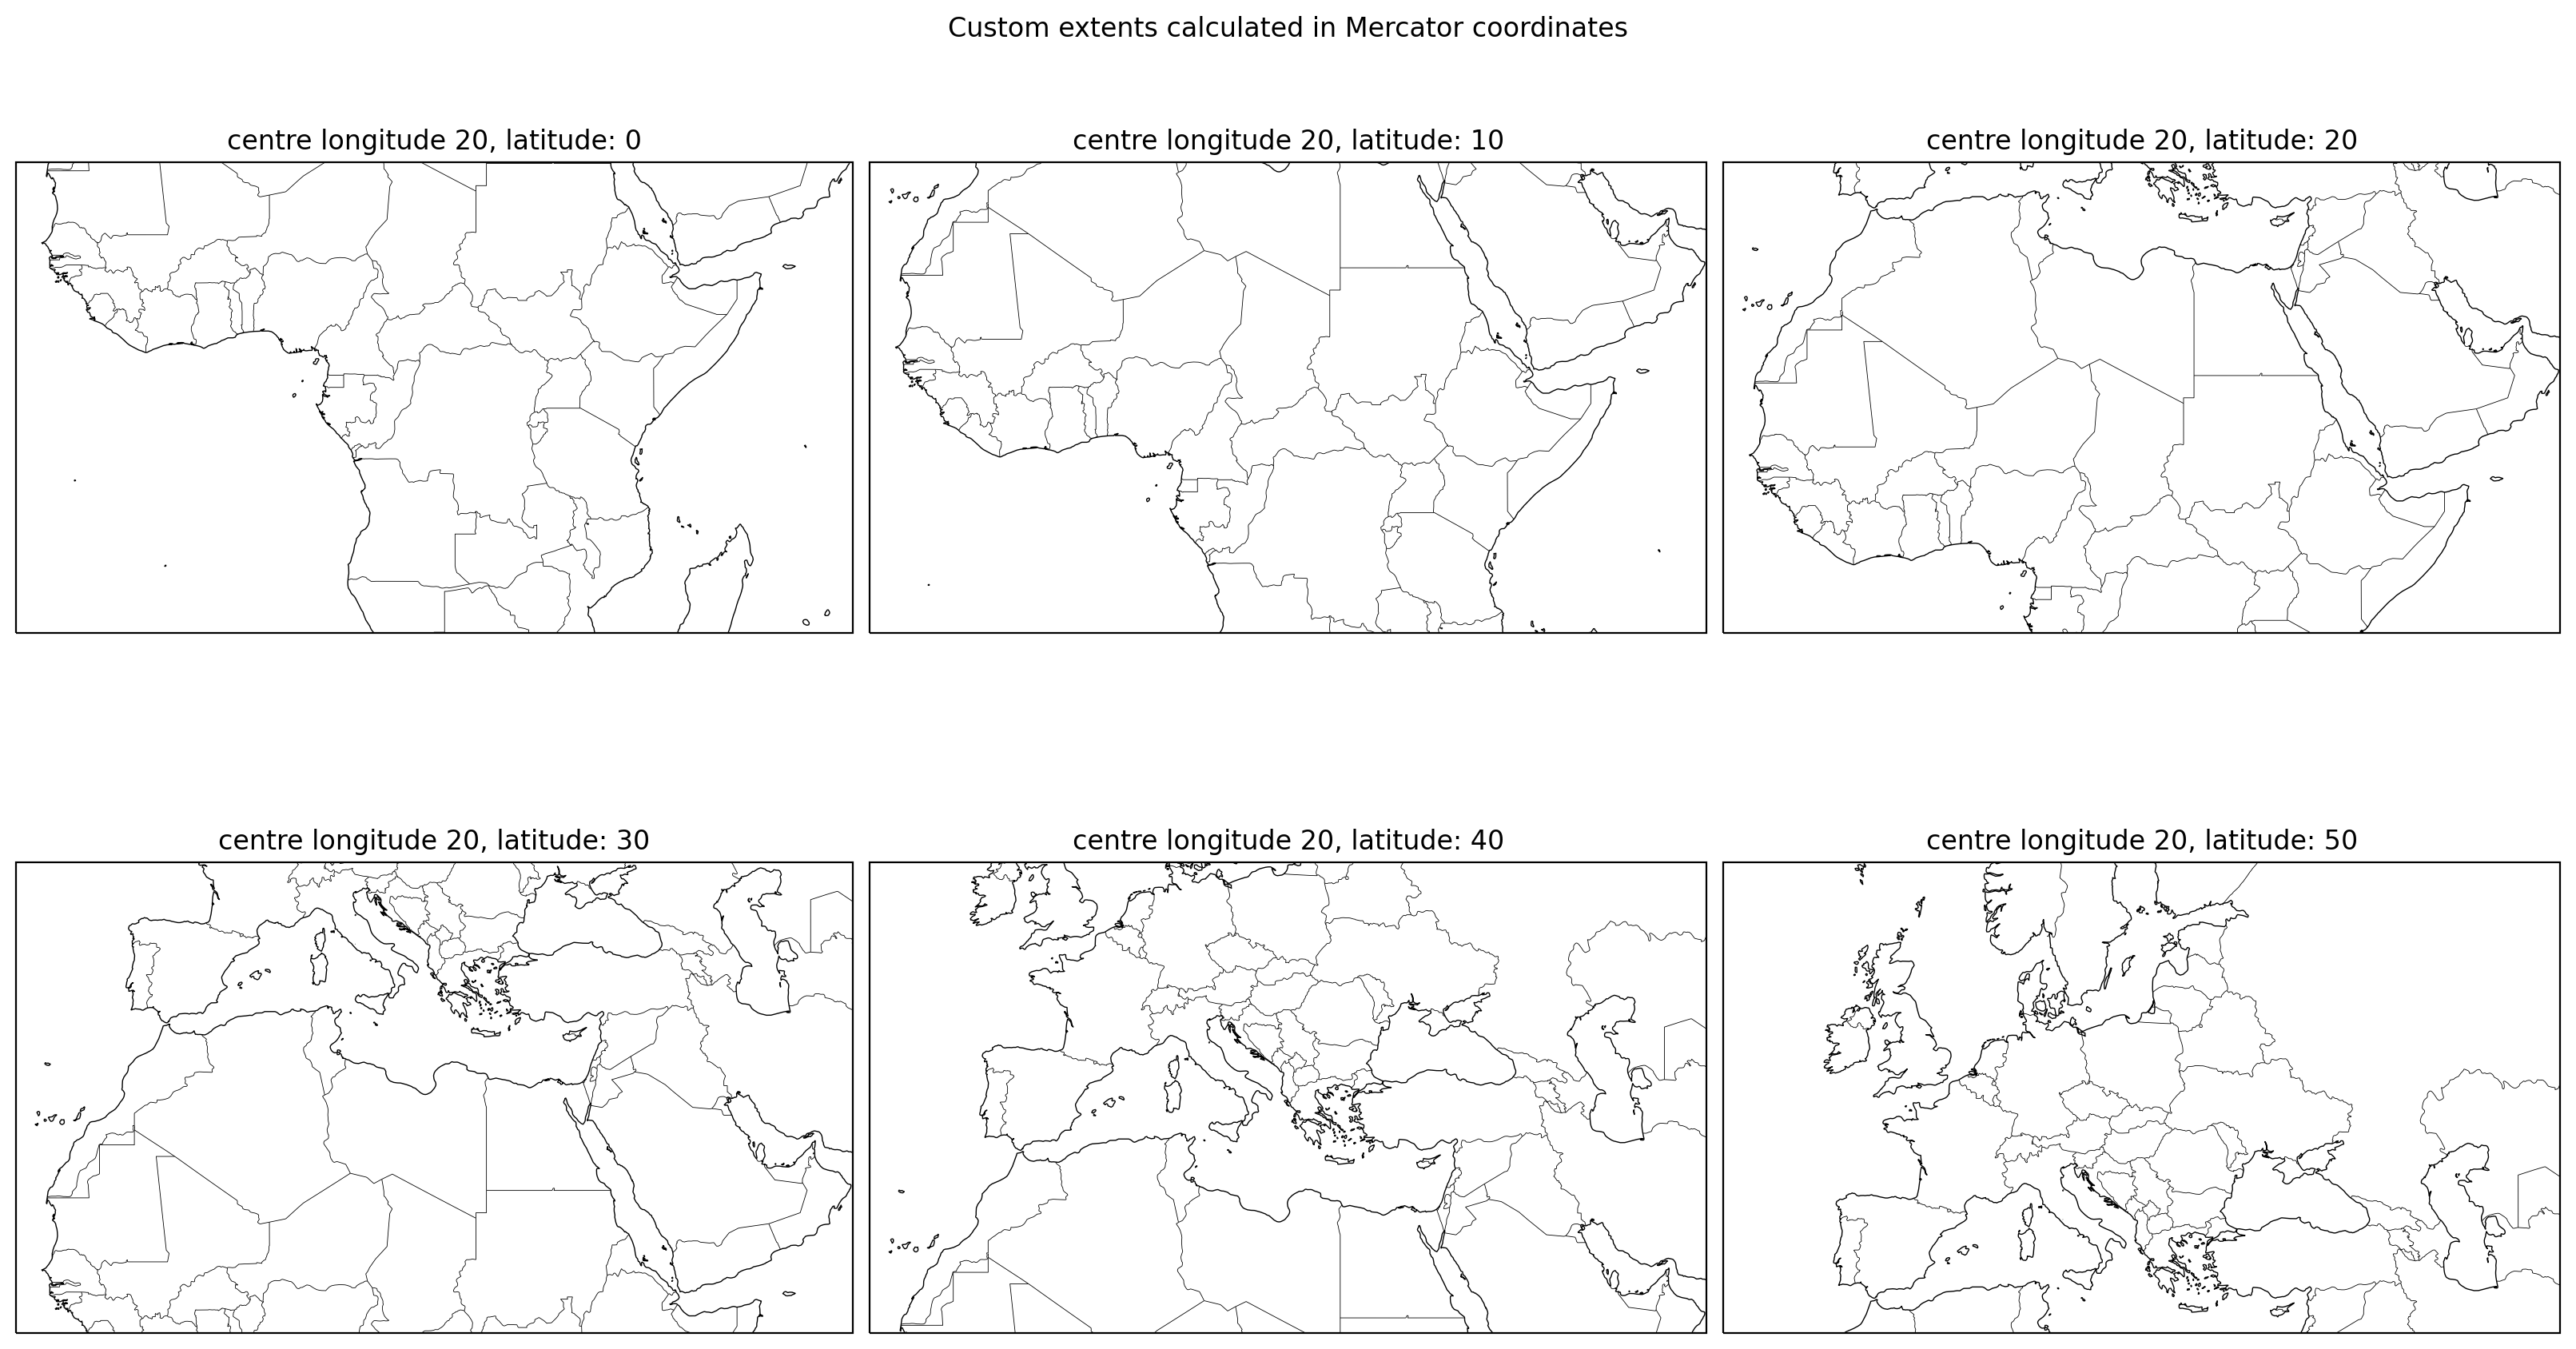

In [3]:

import xarray as xr
import cartopy.feature as cf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


def generate_extent(center_point, zoom, aspect_ratio, out_crs=ccrs.Mercator()):
    """
    Generate extent from central location and zoom level

    Args:
        center_point (tuple(float, float)): center of the map as (longitude, latitude)
        zoom (float):  Zoom level [0 to 10]
        aspect_ratio (tuple): Aspect ratio x/y
        out_crs (cartopy.crs, optional): Out crs for extent values.

    Returns:
        tuple: (lon_min, lon_max, lat_min, lat_max)
    """
    mercator_crs = ccrs.Mercator()
    
    # Define zoom scaling
    zoom_coefficient = 2
    
    # Calculate minimum longitude (min_lon) and maximnum longitude (max_lon)
    lon_min, lon_max = (center_point[0]-(zoom_coefficient*zoom), center_point[0]+(zoom_coefficient*zoom))

    # Transform map center to specified crs (default to Mercator)
    c_mercator = mercator_crs.transform_point(*center_point, src_crs=ccrs.PlateCarree())
    
    # Transform minimum longitude and maximum longitude to specified crs (default to Mercator)
    lon_min = mercator_crs.transform_point(lon_min, center_point[0], src_crs=ccrs.PlateCarree())[0]
    lon_max = mercator_crs.transform_point(lon_max, center_point[0], src_crs=ccrs.PlateCarree())[0]
    
    # Our goal is to calculate minimum latitude (min_lat) and maximum latitude (max_lat) 
    # using center point and distance between min_lon and max_lon
    # To achieve this we will use formula [(lon_distance/lat_distance) = (aspect_ratio[0]/aspect_ratio[1])]
     # Calculate distance between min_lon and max_lon
    lon_distance = (lon_max) - (lon_min)
    
    # To calculate lat_distance, we will proceed accordingly
    lat_distance = lon_distance * aspect_ratio[1] / aspect_ratio[0]
    
    # Now calculate max_lat and min_lan by adding/subtracting half of the distance from center latitude
    lat_max = c_mercator[1] + lat_distance/2
    lat_min = c_mercator[1] - lat_distance/2
    
    # We can return our result in any format (eg. in Mercator coordinates or in degrees)
    if out_crs != ccrs.Mercator():
        lon_min, lat_min = out_crs.transform_point(lon_min, lat_min, src_crs=mercator_crs)
        lon_max, lat_max = out_crs.transform_point(lon_max, lat_max, src_crs=mercator_crs)

    return lon_min, lon_max, lat_min, lat_max

longitude = 20
latitudes = [0,10,20,30,40,50]

mercator_crs = ccrs.Mercator()
fig, axs = plt.subplots(2,3, dpi=200, figsize=(16,9), subplot_kw={'projection': mercator_crs}, constrained_layout=True, facecolor="white")
axs = axs.flatten()

for n, center_point in enumerate(zip(repeat(longitude), latitudes)):
    
    lon_min, lon_max, lat_min, lat_max = generate_extent(center_point, zoom=20, aspect_ratio=(16,9), out_crs=ccrs.PlateCarree())
    axs[n].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Draw coastlines and borders
    axs[n].set_title(f"center longitude {center_point[0]}, latitude: {center_point[1]}")
    axs[n].add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    axs[n].add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
plt.suptitle("Custom extents calculated in Mercator coordinates")

Text(0.5, 1.0, 'Custom extents with 16:9 aspect ratio in Mercator projection')

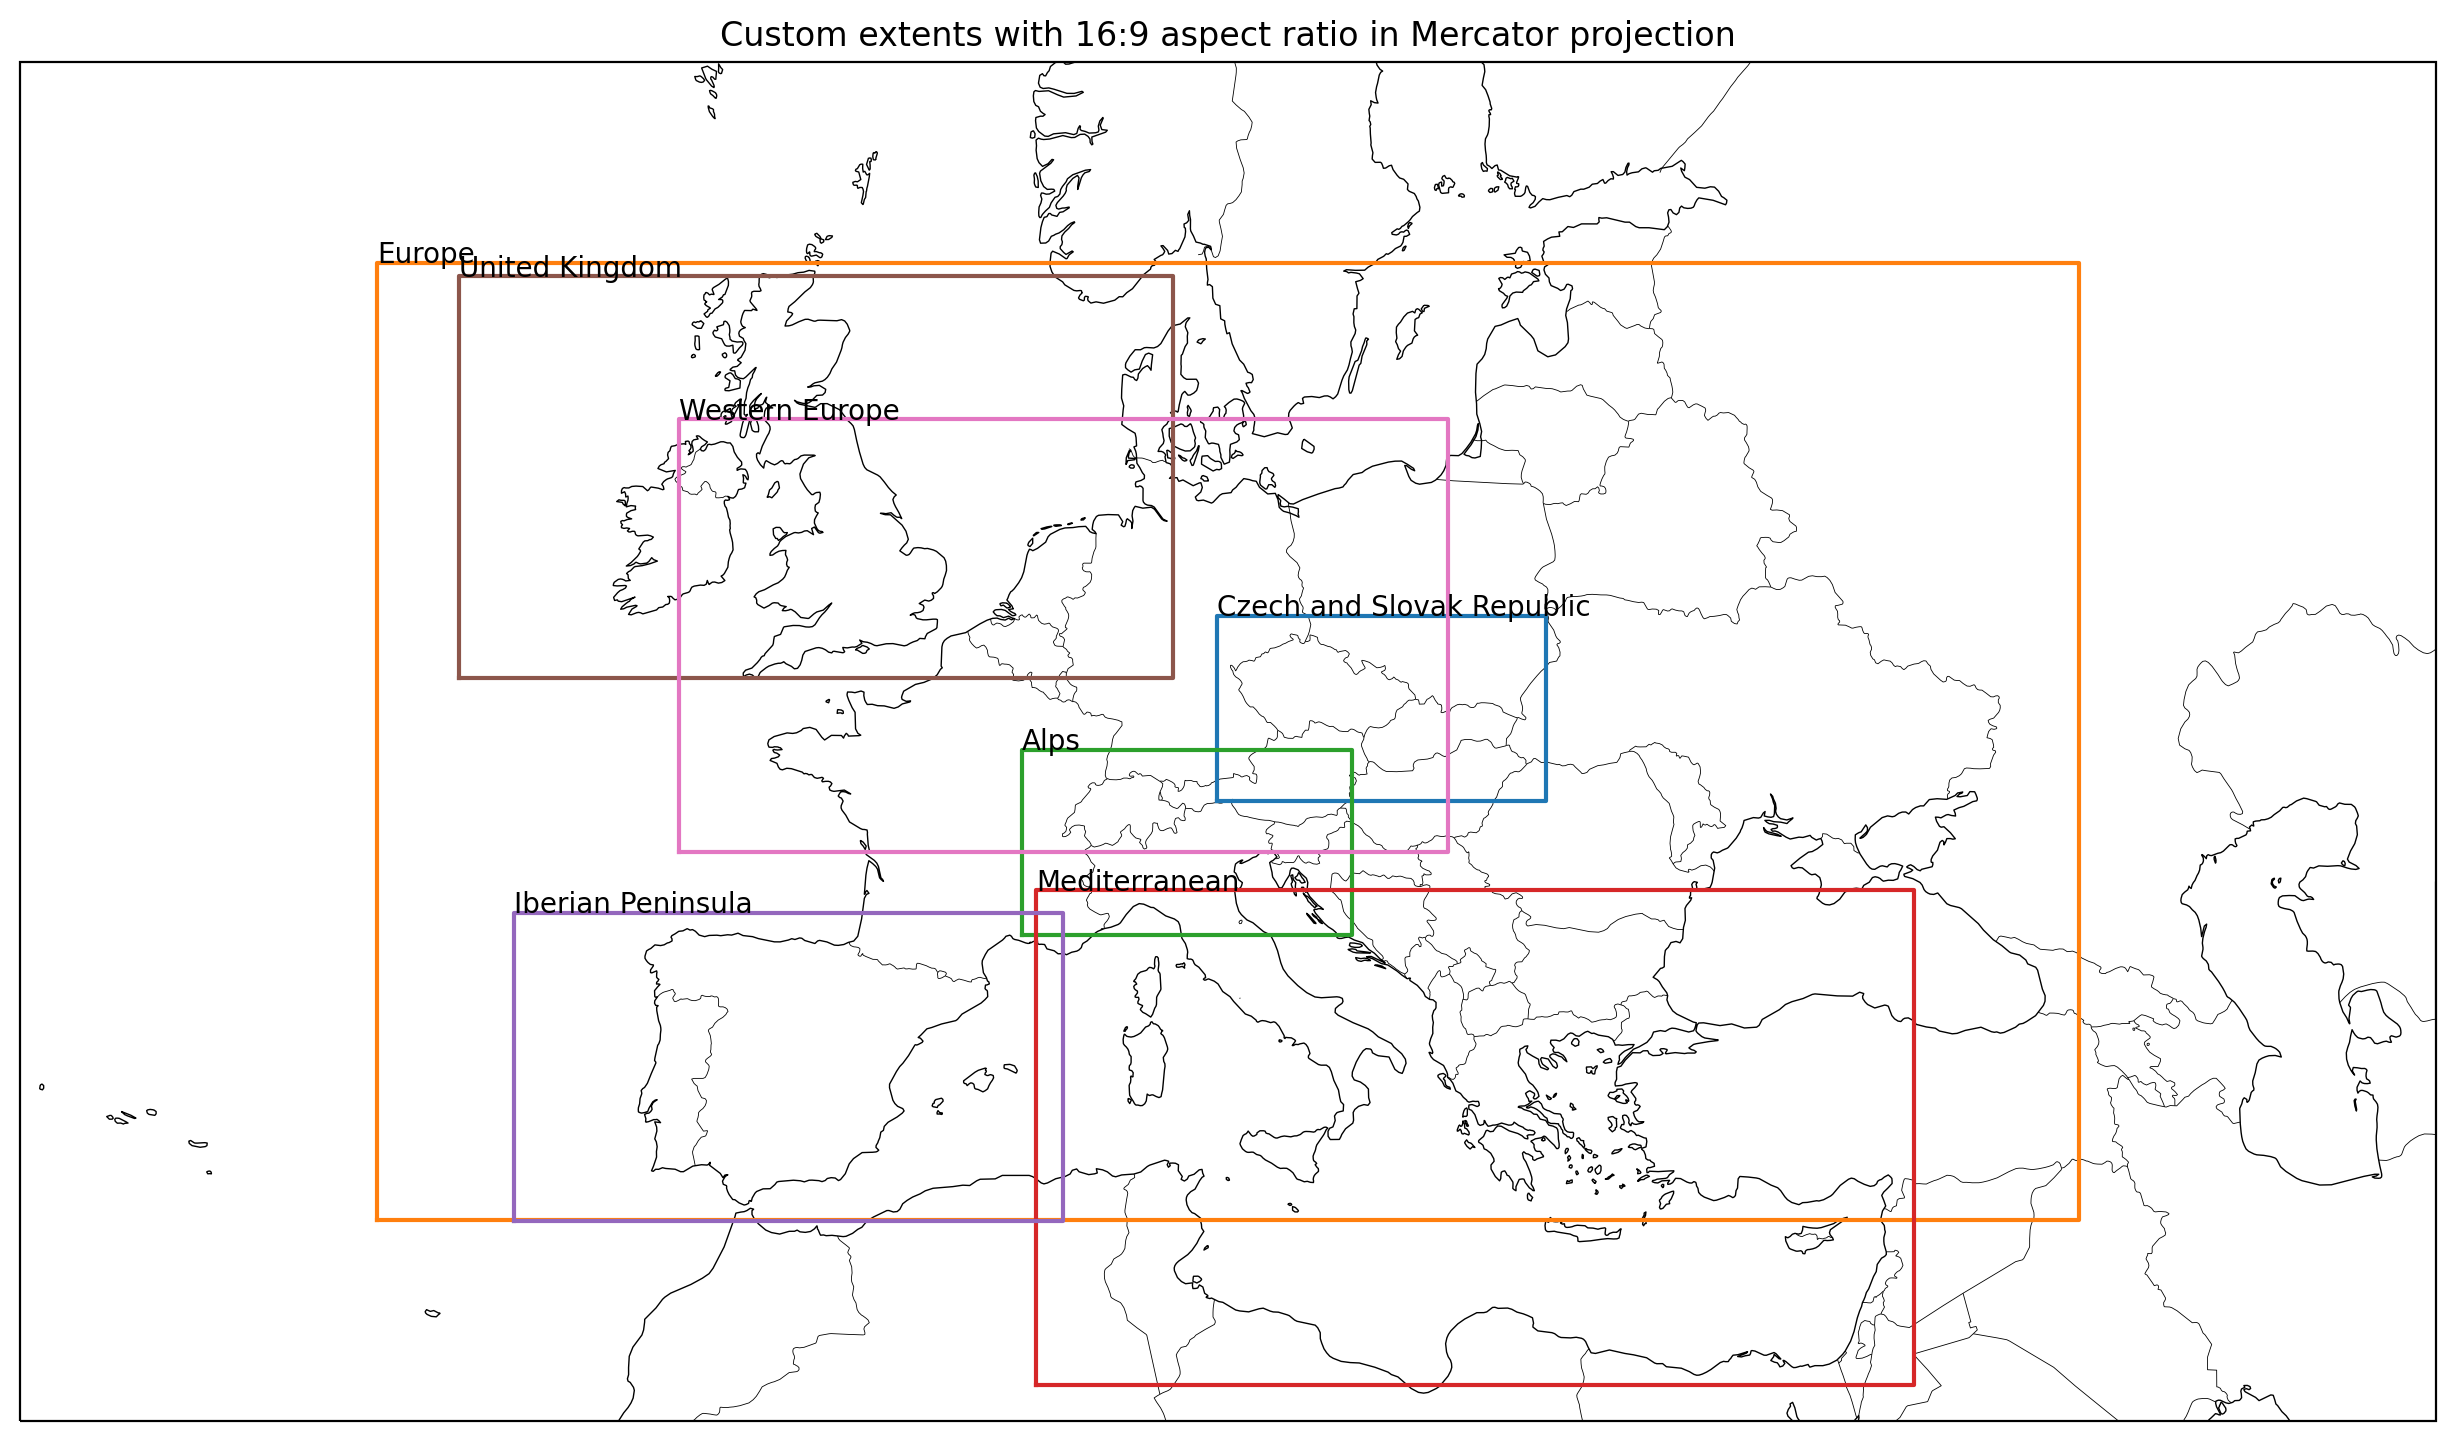

In [4]:
# Example dictionary with extent center points and zoom levels
EXTENTS = {
    "Czech and Slovak Republic" : {
        "center_point" : (17.6, 49.3),
        "zoom" : 3.
    },
    "Europe" : {
        "center_point" : (12, 48.5),
        "zoom" : 15.5
    },
    "Alps" : {
        "center_point" : (10.5, 46),
        "zoom" : 3.
    },
    "Mediterranean" : {
        "center_point" : (21, 38),
        "zoom" : 8.
    },
    "Iberian Peninsula" : {
        "center_point" : (-4, 40),
        "zoom" : 5
    },
    "United Kingdom" : {
        "center_point" : (-3, 54.5),
        "zoom" : 6.5
    },
    "Western Europe" : {
        "center_point" : (6, 51),
        "zoom" : 7
    }
}

# Let's plot all extents with bounding boxes and names on top of it
from collections import namedtuple
from shapely.geometry import Polygon

# Create class that we will store our bounding box information in
Region = namedtuple('Region',field_names=['region_name','lonmin','lonmax','latmin','latmax'])

# Create figure with Mercator projection and reused extent of Europe zoomed out a bit more
plt.figure(dpi=200, figsize=(16,9), facecolor="white")
crs = ccrs.Mercator()
ax = plt.axes(projection=crs, frameon=True)

extent_config = EXTENTS.get("Europe")
lon_min, lon_max, lat_min, lat_max = generate_extent(center_point=extent_config["center_point"], zoom=22,  aspect_ratio=(16,9))
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs = crs)

# Draw coastlines and borders
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

# Plot eaxh extent u
for extent in EXTENTS:
    extent_config = EXTENTS[extent]
    
    lon_min, lon_max, lat_min, lat_max = generate_extent(center_point=extent_config["center_point"], zoom=extent_config["zoom"], aspect_ratio=(16,9), out_crs=ccrs.PlateCarree())
    # print (lon_min, lon_max, lat_min, lat_max)
    lats = [lat_min, lat_min, lat_max, lat_max]
    lons = [lon_min, lon_max, lon_max, lon_min]
    ax.text(lons[0], lats[2], extent, transform=ccrs.PlateCarree()) 
    
    # lon_min, lon_max, lat_min, lat_max = generate_extent(center_point=extent_config["center_point"], zoom=extent_config["zoom"], aspect_ratio=(16,9))
    polygon = Polygon([x for x in zip(lons, lats)])
    ax.plot(*polygon.exterior.xy, transform=ccrs.PlateCarree())
plt.title("Custom extents with 16:9 aspect ratio in Mercator projection")

AttributeError: 'QuadMesh' object has no property 'centre'

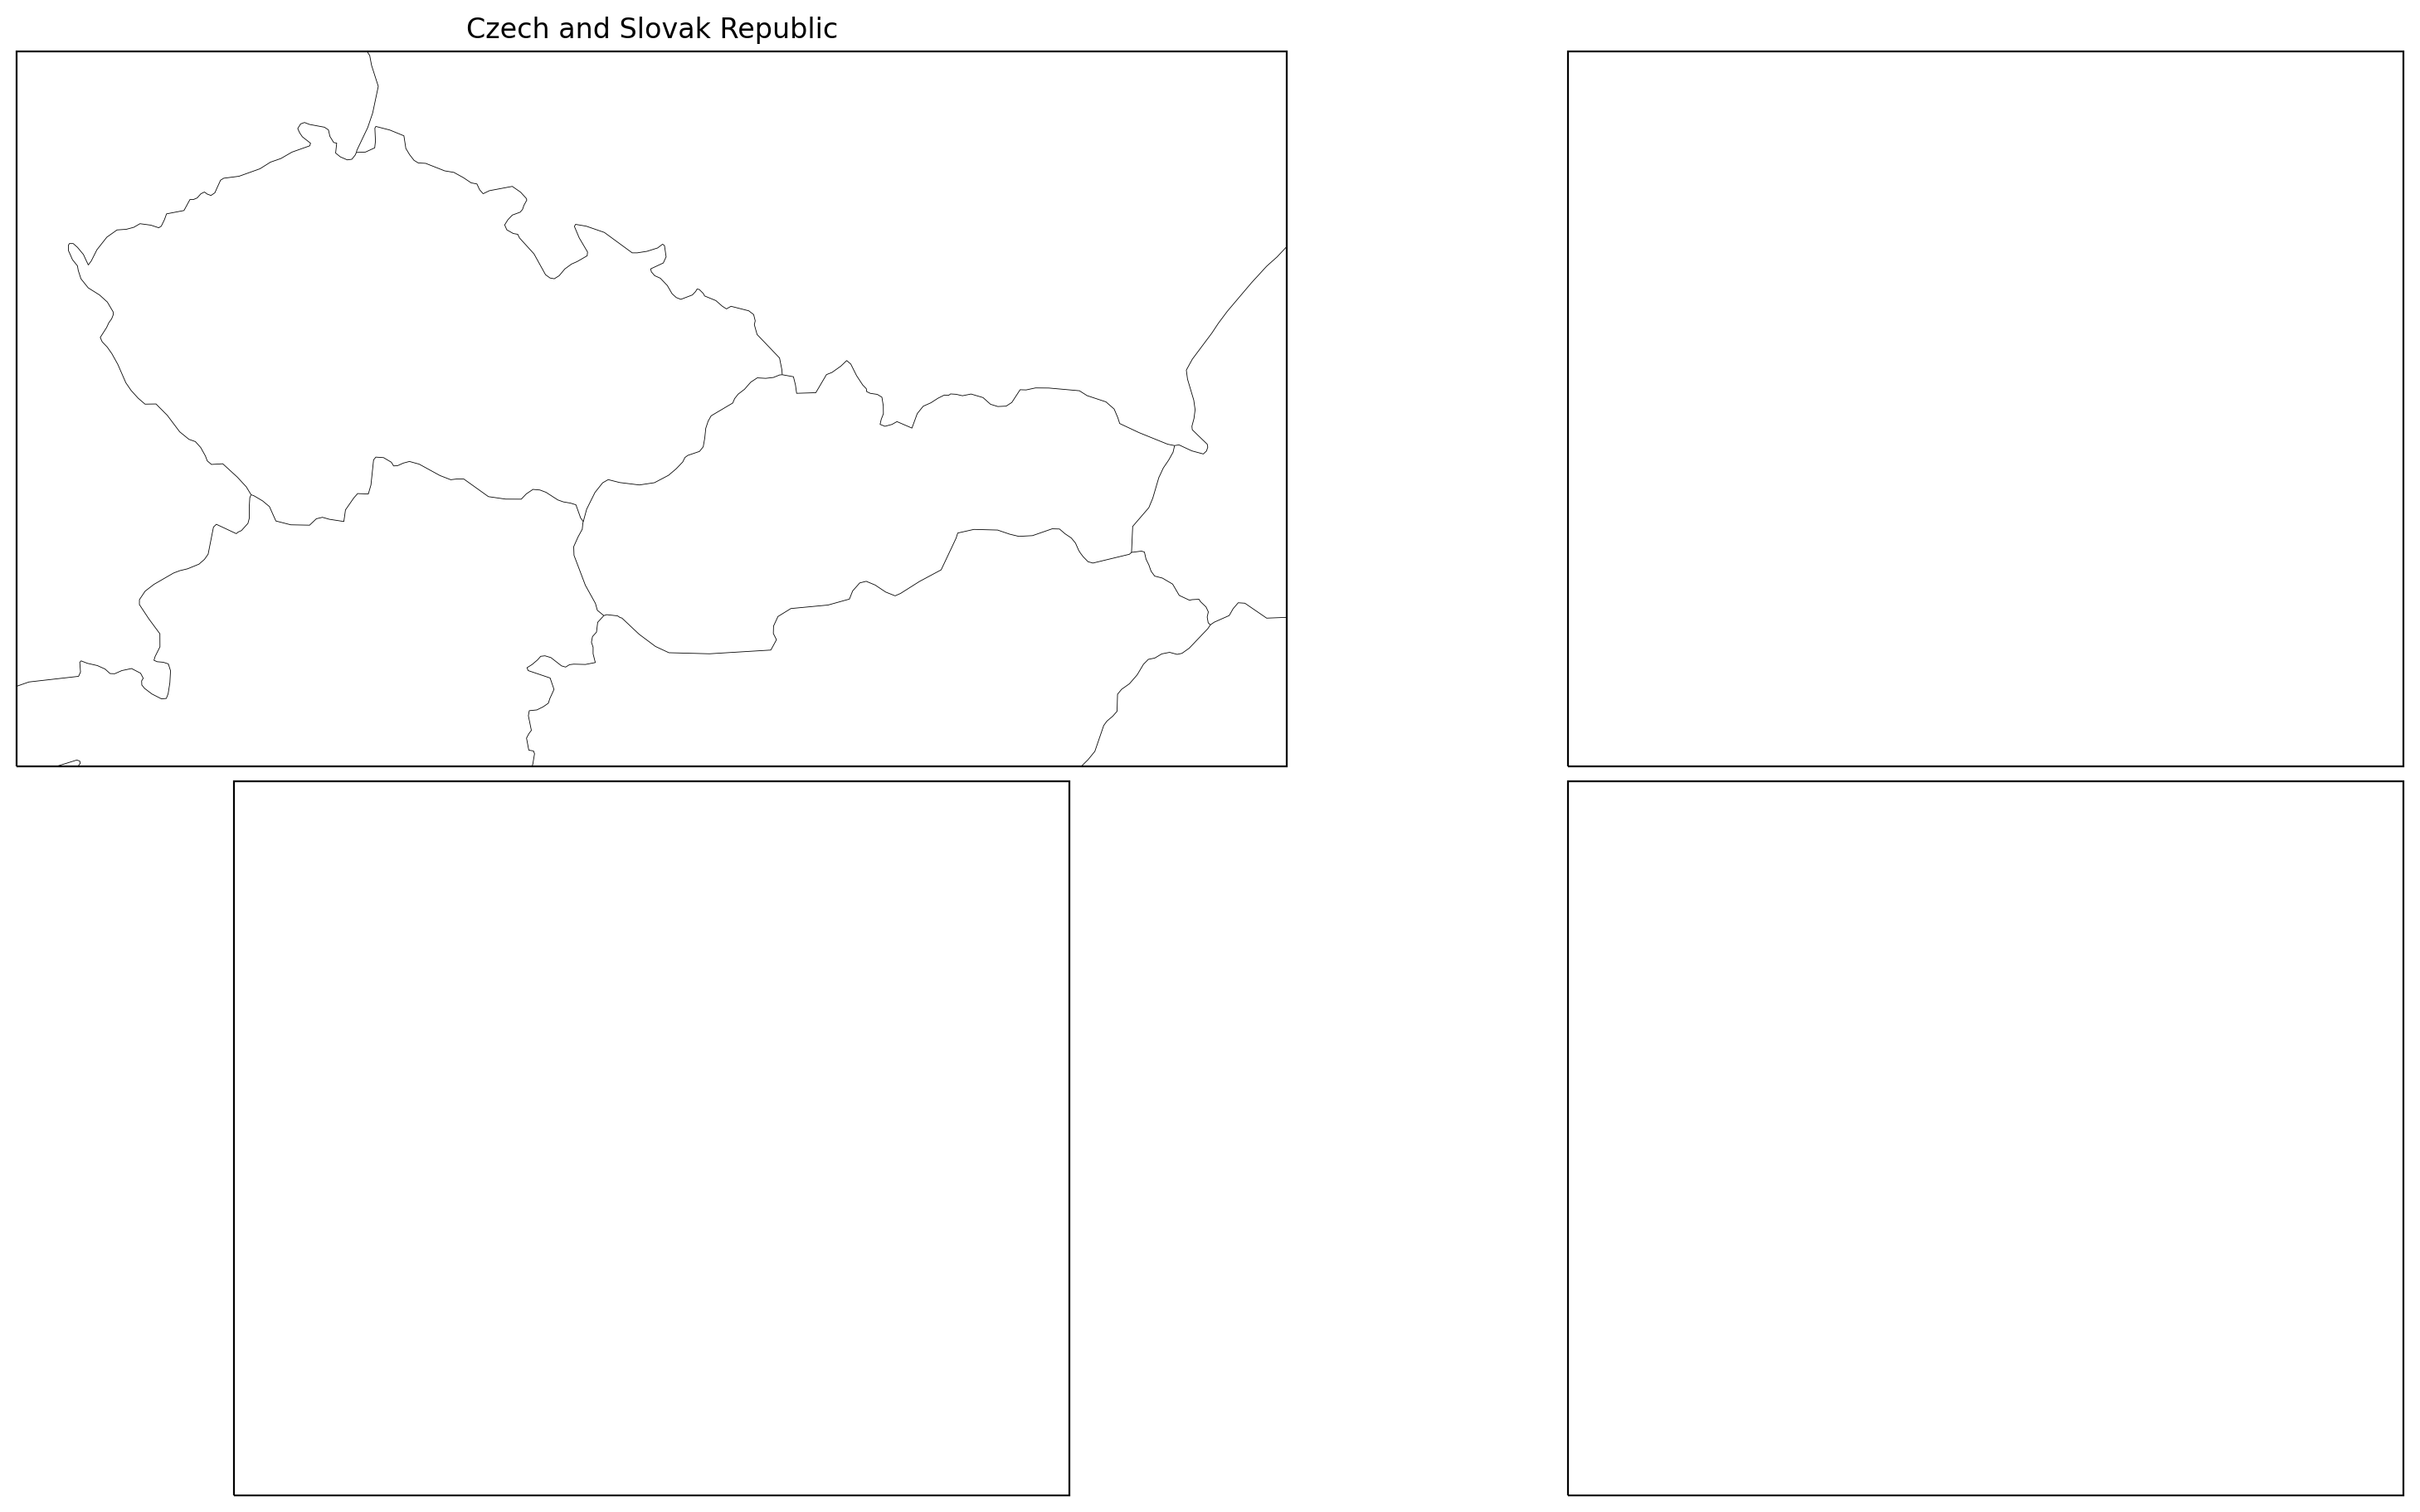

In [5]:
# Now lets plot some sample climatic data from last article
import xarray as xr
from copy import deepcopy

def adjust_longitude(dataset: xr.Dataset) -> xr.Dataset:
    """Swaps longitude coordinates from range (0, 360) to (-180, 180)

    Args:
        dataset (xr.Dataset): xarray Dataset

    Returns:
        xr.Dataset: xarray Dataset with swapped longitude dimensions
    """
    lon_name = "longitude"  # whatever name is in the data

    # Adjust lon values to make sure they are within (-180, 180)
    dataset["_longitude_adjusted"] = xr.where(
        dataset[lon_name] > 180, dataset[lon_name] - 360, dataset[lon_name]
    )
    dataset = (
        dataset.swap_dims({lon_name: "_longitude_adjusted"})
        .sel(**{"_longitude_adjusted": sorted(dataset._longitude_adjusted)})
        .drop(lon_name)
    )

    dataset = dataset.rename({"_longitude_adjusted": lon_name})
    return dataset
        
def get_dataset(data, lon_min, lat_min, lon_max, lat_max):
    # Create copy of the data so we maintain original data
    cropped_dataset = deepcopy(data) 
    cropped_dataset = adjust_longitude(cropped_dataset)
    cropped_dataset = cropped_dataset.sel(
            latitude=slice(lat_max+1, lat_min-1), 
            longitude=slice(lon_min-1, lon_max+1)
        )
    return cropped_dataset

data_path = "data/1month_anomaly_Global_ea_2t_201907_1991-2020_v02.grib"
data = xr.open_dataset(data_path, engine="cfgrib")

crs = ccrs.Mercator()
fig, axs = plt.subplots(2,2, figsize=(16,9), dpi=200, subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True, facecolor="white")
axs = axs.flatten()


for n, extent in enumerate(["Czech and Slovak Republic", "Europe", "Western Europe", "Iberian Peninsula"]):
    extent_config = EXTENTS.get(extent)
    lon_min, lon_max, lat_min, lat_max = generate_extent(center_point=extent_config["center_point"], zoom=extent_config["zoom"],  aspect_ratio=(16,9))
    axs[n].set_extent([lon_min, lon_max, lat_min, lat_max], crs = crs)

    # Draw coastlines and borders
    axs[n].set_title(extent)
    axs[n].add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    axs[n].add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
    
    lon_min, lon_max, lat_min, lat_max = generate_extent(center_point=extent_config["center_point"], zoom=extent_config["zoom"],  aspect_ratio=(16,9), out_crs=ccrs.PlateCarree())
    dataset = get_dataset(data, lon_min, lat_min, lon_max, lat_max)
    clrmsh = dataset["t2m"].plot.pcolormesh(ax=axs[n], transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-5, vmax=5, center=0, cmap="RdBu_r", add_labels=False)
    
plt.colorbar(clrmsh, ax=axs[[1,3]], orientation="vertical", pad = .1, shrink=0.8, aspect=30)
plt.suptitle("Temperature Anomaly in July 2019 [°C]", size=20)
plt.show()